In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import random as rd

In [2]:
merged_data = pd.read_csv("../result/the_result_file.csv", index_col=0)
merged_data.dropna(inplace=True)

y = merged_data.grav
merged_data_sans_grav = merged_data.drop(['grav'],axis = 1)

In [3]:
def encoding(data):
    colnames = data.columns
    
    result = pd.DataFrame(index=data.index)
    
    for colname in colnames:
        dum = pd.get_dummies(data[colname], prefix=colname)
        result = pd.merge(result, dum, left_index=True, right_index=True)
    return result


encoded = encoding(merged_data)

In [4]:
X = encoded

In [5]:
n = len(X)

In [6]:
r = len(X.columns)

In [7]:
K = 4

In [8]:
def Odist( _D, _F, _X=X):
    _D = np.matrix(_D)
    _F = np.matrix(_F)
    _X = np.matrix(_X)
    
    mat = _X - _D.dot(_F)
    
    dist = np.linalg.norm(mat)
    return dist
    

In [9]:
def ykj(d,x):
    n=len(x)
    r = len(x[0])
    y = np.zeros((K, r))
    
    for k in range(0,K):
        nk = 0
        for i in range(0,n):
            nk = nk + d[i][k]
        if not nk == 0:
            for j in range(0,r):
                for i in range(0,n):
                    y[k][j] = y[k][j] + d[i][k]*x[i][j]
                y[k][j] = y[k][j] / nk
    return y
            


def fkj(y):
    f = y > 0.5
    f = f.astype(int)
    return f

In [10]:
def somme23(f, i, k, x):
    r = len(x[0])
    s = 0
    for j in range(0,r):
        s = s + (x[i][j] - f[k][j])*(x[i][j] - f[k][j])
    return s

def dik(x, f):
    n = len(x)
    d = np.array([[1]*K]*n)
    
    for i in range(n):
        for k in range(K):
            sk = somme23(f, i ,k, x)
            for l in range(K):
                if not l==k:
                    sl = somme23(f, i ,l, x)
                    if sl <= sk:
                        d[i][k] = 0
                        
    return d

In [11]:
def Dinit(long, k):
    d = np.array([[0]*k]*long)
    
    for i in range(long):
        r = rd.randint(0,k-1)
        d[i][r] = 1
    return d

In [12]:
def Dperfect(long, k, y):
    d = np.array([[0]*k]*long)
    
    for i in range(long):
        r = y[i] - 1 
        d[i][int(r)] = 1
    return d

In [23]:
def algo_final(data = merged_data, 
               nb_clusters=K, 
               sample=None, 
               init='rand',
               print_mode=True,
               cible='grav'):
    
    y = pd.DataFrame(data[cible])
    y = np.array(y)
    
    
    # Encoding
    enco = encoding(data)
    
    # Sampling
    if not sample is None:
        enco = enco.sample(frac=sample)
    
    X = np.array(enco)
    
    
    # Init
    if init == 'rand':
        # Random Init
        D = Dinit(len(X), nb_clusters)    
        F = Dinit(nb_clusters, len(X[0]))
    elif init == 'semi_rand':
        D = Dinit(len(X), nb_clusters)    
        Y = ykj(D, X)
        F = fkj(Y)
    elif init == 'perf':
        D = Dperfect(len(X), nb_clusters, y)
        Y = ykj(D, X)
        F = fkj(Y)
    else:
        from sklearn.decomposition import NMF
        model = NMF(n_components=nb_clusters, init='random', random_state=0)
        W = model.fit_transform(X)
        H = model.components_
        W = np.array(W)
        H = np.array(H)
        D = dik(X,H)
        Y = ykj(D, X)
        F = fkj(Y)
    
    
    norms = []
    
    
    Onorm = Odist(_D=D, _F=F, _X=X)
    
    etape = 0
    while True:
        etape += 1
        if print_mode:
            print('etape ' + '{}'.format(etape))
            print(Onorm)
            print("=================")
        norms.append(Onorm)

        D1 = dik(X,F)
        Y1 = ykj(D1,X)
        F1 = fkj(Y1)
        
        Onew = Odist(_D=D1, _F=F1, _X=X)
        
        if Onew < Onorm:
            Onorm = Onew
            D = D1
            Y = Y1
            F = F1
        else: 
            break
    
    result = {'norms': norms, 'D': D, 'F': F}
    if print_mode and (len(result['norms']) > 1):
        plt.plot(result['norms'])
        plt.show()
        plt.close()
        
    os.system('say "fini"')
    return result

etape1
228.324330723
etape2
198.43134833
etape3
187.085541932
etape4
184.740358341
etape5
181.7305698


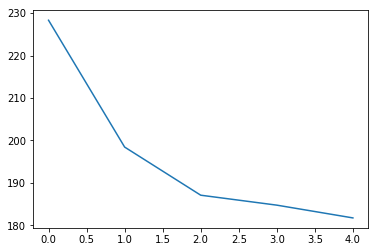

In [21]:
app = algo_final(sample = 0.1, init='rand')

etape1
113.736537665
etape2
111.789981662


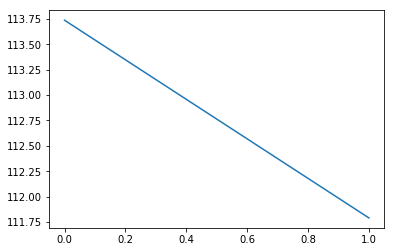

In [22]:
colonnes = ['grav', 'catu', 'catv_gen', 'choc', 'mom', 'catvopp_gen', 'age']
data2 = pd.DataFrame(merged_data[colonnes])
app2 = algo_final(data=data2, sample=0.1, init='else')

etape 1
446.95637371
etape 2
427.334763388
etape 3
360.59395447
etape 4
350.004285688
etape 5
345.895938109
etape 6
343.82117445


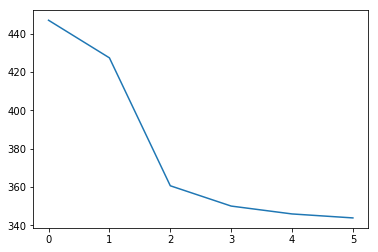

In [29]:
colonnes = ['grav', 'catv_gen', 'choc', 'mom', 'catvopp_gen', 'agg', 'int']
data3 = pd.DataFrame(merged_data[colonnes])
app3 = algo_final(data=data3, sample=None, init='rand')

In [70]:
def qualite(table, cible):
    cible = np.array(cible)
    table = np.array(table)
    longueur = len(cible)
    
    import itertools
    perms = list(itertools.permutations([0, 1, 2, 3]))
    pcts = []
    for perm in perms:
        pct = 0
        for i in range(longueur):
            j = int( cible[i] - 1 )
            if table[i][perm[j]] == 1:
                pct += 1
        pct = pct / longueur
        pcts.append(pct)
        
    argmax = pcts.index(max(pcts))
    pct = pcts[argmax]
    
    print(pct)
    print(perms[argmax])
    return pct
    

In [71]:
q3 = qualite(app3['D'], y)

0.3919458303635068
(0, 2, 1, 3)


In [72]:
colonnes = ['grav', 'catv_gen', 'choc', 'mom', 'catvopp_gen', 'agg', 'int']
data4 = pd.DataFrame(merged_data[colonnes])
app4 = algo_final(data=data4, sample=None, init='else')
q4 = qualite(app4['D'], y)

etape 1
334.870124078
0.40894511760513186
(0, 1, 3, 2)


In [ ]:
app5 = algo_final(data=merged_data, sample=None, init='rand')
q4 = qualite(app5['D'], y)

etape 1
727.162980356
etape 2
670.798777578
etape 3
588.310292278
